# CNN_CIFAR-10_Random_Cropping

# Not Correct Implementation

/Users/sungchul/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/sungchul/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
epoch_number    : 0
cost_this_epoch : 928.8606482744217

epoch_number    : 1
cost_this_epoch : 803.9458779096603

epoch_number    : 2
cost_this_epoch : 748.589822769165

epoch_number    : 3
cost_this_epoch : 707.3901767730713

epoch_number    : 4
cost_this_epoch : 679.1131598949432

epoch_number    : 5
cost_this_epoch : 657.0819963216782

epoch_number    : 6
cost_this_epoch : 640.5709227919579

epoch_number    : 7
cost_this_epoch : 619.5571112036705

epoch_number    : 8
cost_this_epoch : 601.2264323830605

epoch

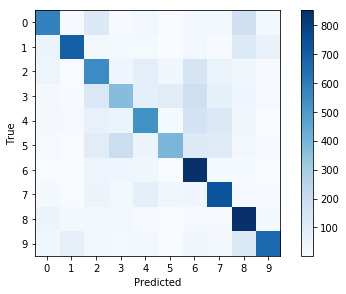

<Figure size 432x288 with 0 Axes>

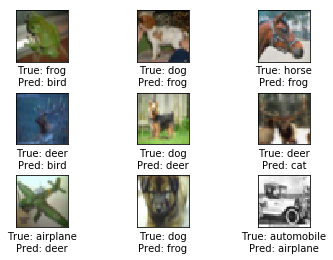

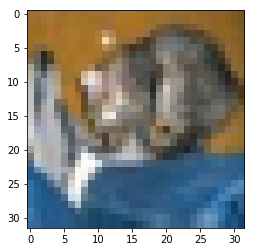

<Figure size 432x288 with 0 Axes>

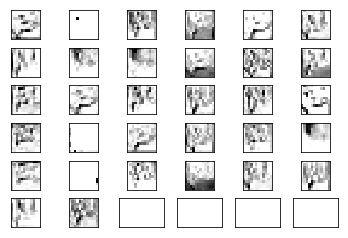

<Figure size 432x288 with 0 Axes>

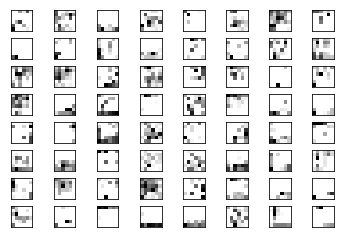

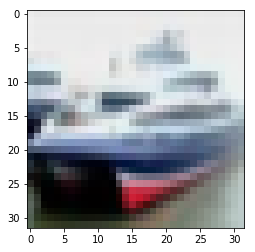

<Figure size 432x288 with 0 Axes>

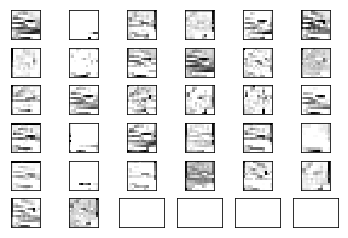

<Figure size 432x288 with 0 Axes>

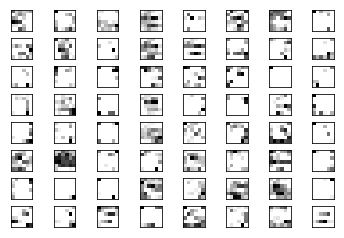

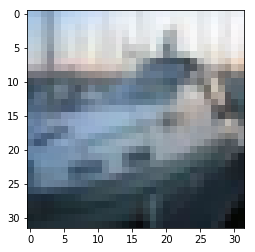

<Figure size 432x288 with 0 Axes>

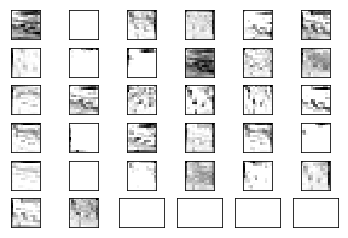

<Figure size 432x288 with 0 Axes>

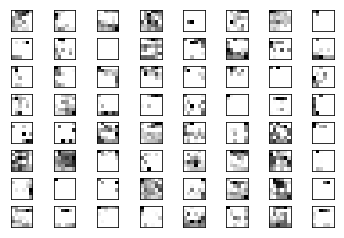

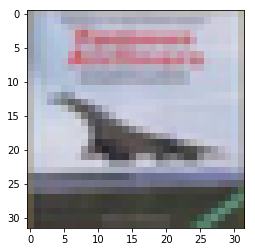

<Figure size 432x288 with 0 Axes>

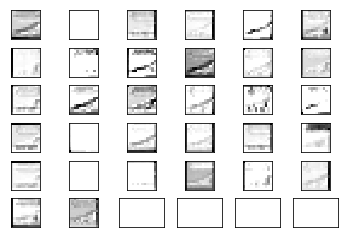

<Figure size 432x288 with 0 Axes>

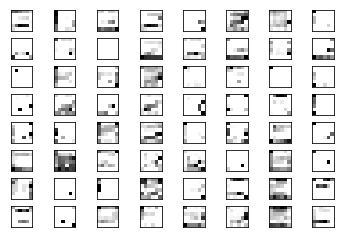

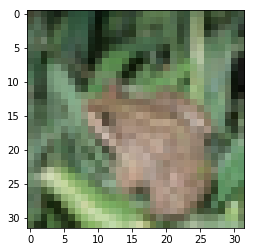

<Figure size 432x288 with 0 Axes>

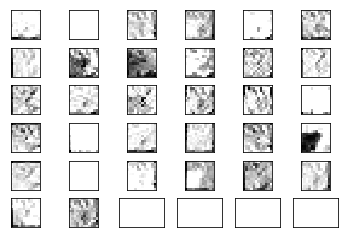

<Figure size 432x288 with 0 Axes>

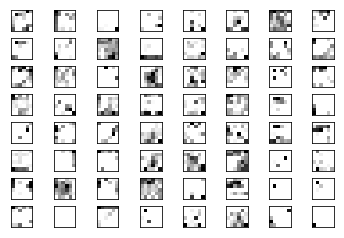

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix

import cache    # module from Hvass Labs
import dataset  # module from Hvass Labs
import download # module from Hvass Labs
import cifar10  # module from Hvass Labs

import utils

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size_train = 50000
data_size_test = 10000
batch_size = 100
lr = 1e-3
epoch = 15
cropped_size = (24, 24, 3)
img_size_cropped = 24


""" Data Loading """
def load_cifar10():
    # make directory if not exist
    if not os.path.isdir("data"):
        os.mkdir("data")
    if not os.path.isdir("data/CIFAR-10"):
        os.mkdir("data/CIFAR-10")

    # download and extract if not done yet
    # data is downloaded 
    # from data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    # to data_path  = "data/CIFAR-10/"
    cifar10.data_path = "data/CIFAR-10/"
    cifar10.maybe_download_and_extract()

    # load data
    x_train, y_train_cls, y_train = cifar10.load_training_data()
    x_test, y_test_cls, y_test = cifar10.load_test_data()
    class_names = cifar10.load_class_names()

    x_train = x_train.astype(np.float32)
    y_train_cls = y_train_cls.astype(np.int32)
    y_train = y_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_test_cls = y_test_cls.astype(np.int32)
    y_test = y_test.astype(np.float32)

    data = (x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names)

    return data

# x_train.shape     :  (50000, 32, 32, 3)
# x_test.shape      :  (10000, 32, 32, 3)
# y_train.shape     :  (50000, 10)
# y_test.shape      :  (10000, 10)
# y_train_cls.shape :  (50000,)
# y_test_cls.shape  :  (10000,)
data = load_cifar10()
x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names = data


""" Graph Construction """
# tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
y_cls = tf.placeholder(tf.int32, shape=(None,), name='y_cls')
is_train = tf.placeholder(tf.bool, shape=(), name='is_train')

# cropping ##########################################################################
# crop original images x by random cropping during train and 
# center cropping during test

def pre_process_img(img): #, is_train=is_train, cropped_size=cropped_size):
    # img: a single image 
    # is_train: a placeholder for a boolean whether to build the training graph
    # cropped_size: (img_size_cropped, img_size_cropped, num_channels)

    if is_train is not None:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        # cropped_size = (img_size_cropped, img_size_cropped, num_channels) 
        image = tf.random_crop(img, size=cropped_size)

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)

        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For not training, i.e., test, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(img, \
                                                       target_height=img_size_cropped, \
                                                       target_width=img_size_cropped)

    return image
    
x_cropped = tf.map_fn(lambda img: pre_process_img(img), x)
# cropping ##########################################################################

# weights and layers #################################################################

# convolution layer 1
# input and input.shape:   x,     (None, 24, 24, 3)
# output and output.shape: conv1, (None, 12, 12, 32)
conv1_W = tf.get_variable("conv1_W", \
                          shape=(3,3,3,32), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
c1 = tf.nn.conv2d(x_cropped, conv1_W, \
                  strides=(1,1,1,1), padding='SAME') # (None, 24, 24, 32)
co1 = tf.nn.relu(c1) # (None, 24, 24, 32)
conv1 = tf.nn.max_pool(co1, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 12, 12, 32)

# convolution layer 2
# input and input.shape:   conv1, (None, 12, 12, 32)
# output and output.shape: conv2, (None, 6, 6, 64)
conv2_W = tf.get_variable("conv2_W", \
                          shape=(3,3,32,64), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
c2 = tf.nn.conv2d(conv1, conv2_W, strides=(1,1,1,1), \
                     padding='SAME') # (None, 12, 12, 64)
co2 = tf.nn.relu(c2) # (None, 12, 12, 64)
conv2 = tf.nn.max_pool(co2, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 6, 6, 64)

# fully connected layer
# input and input.shape:   conv2, (None, 6, 6, 64)
# output and output.shape: fc,    (None, 256) 
flatten = tf.reshape(conv2, (-1, 2304)) # (None, 2304) 
fc_W = tf.get_variable("fc_W", \
                        shape=(2304,256), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
fc = tf.matmul(flatten, fc_W) # (None, 256) 
fc = tf.nn.relu(fc) # (None, 256) 

# output layer
# input and input.shape:   fc,     (None, 256) 
# output and output.shape: logits, (None, 10) 
out_W = tf.get_variable("out_W", \
                        shape=(256, 10), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
logits = fc @ out_W # (None, 10) 

# weights and layers #################################################################

# y_pred, and y_pred_cls 
y_pred = tf.nn.softmax(logits, name='y_pred') # probabilities
y_pred_cls = tf.argmax(logits, axis=1, output_type=tf.int32)

# cross_entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y)
cost = tf.reduce_mean(cross_entropy)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# test accuracy
# you have to put test sets to compute test_accuracy
correct_bool = tf.equal(y_cls, y_pred_cls)
test_accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32))


""" Train and Test """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    
    # run gradient descent
    for i in range(epoch):
        if 1:
            # perform random permutaion
            idx = np.random.permutation(np.arange(data_size_train)) 
            x_batch = x_train[idx]
            y_batch = y_train[idx]
        else:
            # don't perform random permutaion
            x_batch = x_train
            y_batch = y_train
            
        cost_this_epoch = 0
        for batch_number in range(int(data_size_train/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            y_b = y_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b, y: y_b, is_train: True}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            cost_this_epoch += cost_now
            
        print('epoch_number    :', i)
        print('cost_this_epoch :', cost_this_epoch)
        print()

            
    # compute test accuracy and print confusion matrix 
    x_data = x_test
    y_data = y_test
    y_cls_data = y_test_cls
    y_test_cls_pred = np.zeros(shape=(data_size_test), dtype=np.int32)
    test_accuracy_list = []
    for batch_number in range(int(data_size_test/batch_size)): 
        x_b = x_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_b = y_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_cls_b = y_cls_data[batch_number*batch_size:(batch_number+1)*batch_size]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, is_train: False}
        test_accuracy_temp, y_test_cls_pred_now = sess.run([test_accuracy,y_pred_cls],
                                                           feed_dict=feed_dict)
        test_accuracy_list.append(test_accuracy_temp)
        y_test_cls_pred[batch_number*batch_size:(batch_number+1)*batch_size] = \
            y_test_cls_pred_now
        
    print('Test Accuracy: ', np.mean(np.array(test_accuracy_list)))
    
    cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(10))
    plt.yticks(tick_marks, range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    plt.savefig('img/cm.png')
    plt.close()
    
    
    # collect info of first 9 test images with false prediction
    images = []
    cls_true = []
    cls_pred = []
    img_shape = (32, 32, 3)
    num_false_prediction = 0
    i = 0
    while num_false_prediction < 9:
        x_b = [x_test[i]]
        y_b = [y_test[i]]
        y_cls_b = [y_test_cls[i]]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, is_train: False}
        bool_now, y_pred_cls_now = sess.run([correct_bool, y_pred_cls], \
                                            feed_dict=feed_dict)
        if bool_now[0] == False:
            images.append(x_b[0])
            cls_true.append(y_cls_b[0])
            cls_pred.append(y_pred_cls_now[0])
            num_false_prediction += 1
        i += 1
    images = images[0:9]
    cls_true = cls_true[0:9]
    cls_pred = cls_pred[0:9]

        
    # plot 9 test images with false prediction
    n = len(images)
    sqrt_n = int(np.ceil(np.sqrt(n)))
    
    plt.figure()
    fig, axes = plt.subplots(sqrt_n, sqrt_n)
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i < n:
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            if (cls_true is not None) and (cls_pred is not None):
                xlabel = "True: {0}\nPred: {1}".format(class_names[cls_true[i]], \
                                                       class_names[cls_pred[i]])
            elif (cls_true is not None) and (cls_pred is None):
                xlabel = "True: {0}".format(class_names[cls_true[i]])
            elif (cls_true is None) and (cls_pred is not None):
                xlabel = "Pred: {0}".format(class_names[cls_pred[i]])
            else:
                xlabel = ""
            ax.set_xlabel(xlabel)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
    
    # plot_test_images_in_input_conv1_conv2_layers(self, num_test_images=2):
    num_test_images = 5
    for i in range(num_test_images):
        image0 = x_test[i]
        utils.plot_one_image(image0, (32, 32, 3), cls_true=None, cls_pred=None)

        feed_dict = {x: [image0], is_train: False}
        image0_layer1, image0_layer2 = sess.run([conv1, conv2], feed_dict=feed_dict)
        
        # image0_layer1.shape = (1, 16, 16, 32)
        # image0_layer2.shape = (1, 8, 8, 64)
        image0_layer1 = image0_layer1[0]
        image0_layer2 = image0_layer2[0]

        utils.plot_many_images_3d(image0_layer1)
        utils.plot_many_images_3d(image0_layer2)

# Correct Implementation

/Users/sungchul/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/sungchul/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Data has apparently already been downloaded and unpacked.
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta
epoch_number    : 0
cost_this_epoch : 948.7333083152771

epoch_number    : 1
cost_this_epoch : 822.2542595863342

epoch_number    : 2
cost_this_epoch : 755.5951905250549

epoch_number    : 3
cost_this_epoch : 715.1623349189758

epoch_number    : 4
cost_this_epoch : 680.698500752449

epoch_number    : 5
cost_this_epoch : 656.2120420336723

epoch_number    : 6
cost_this_epoch : 634.5499392151833

epoch_number    : 7
cost_this_epoch : 615.1333872079849

epoch_number    : 8
cost_this_epoch : 597.7963093519211

epoch

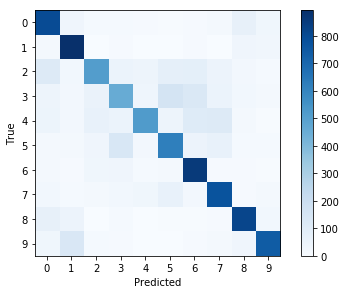

<Figure size 432x288 with 0 Axes>

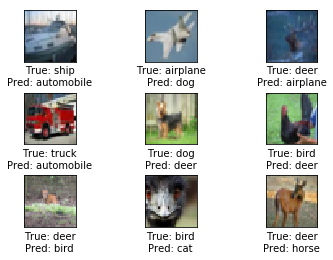

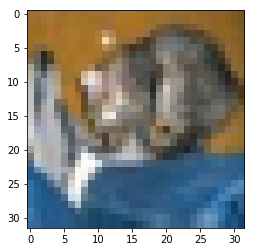

<Figure size 432x288 with 0 Axes>

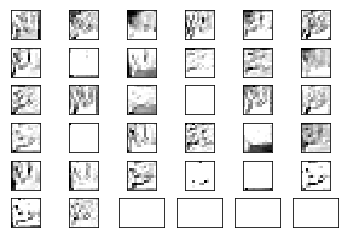

<Figure size 432x288 with 0 Axes>

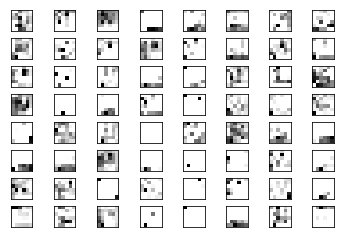

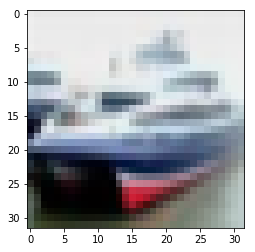

<Figure size 432x288 with 0 Axes>

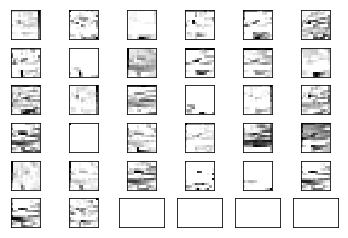

<Figure size 432x288 with 0 Axes>

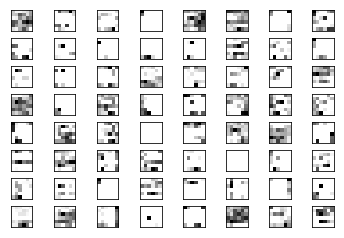

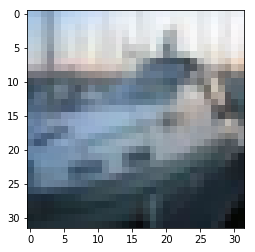

<Figure size 432x288 with 0 Axes>

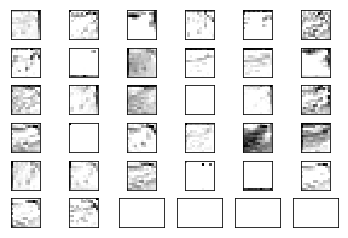

<Figure size 432x288 with 0 Axes>

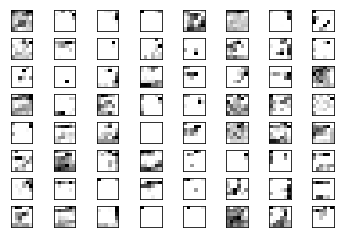

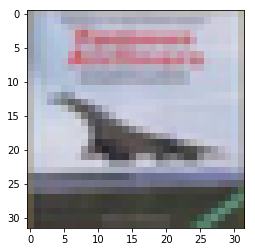

<Figure size 432x288 with 0 Axes>

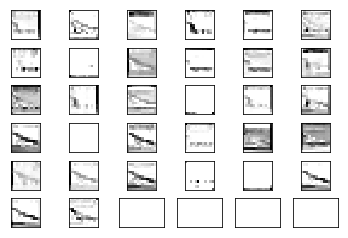

<Figure size 432x288 with 0 Axes>

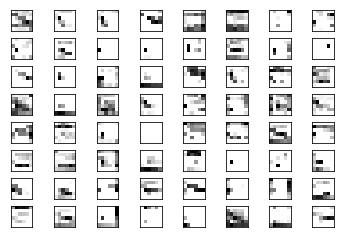

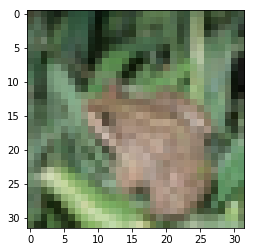

<Figure size 432x288 with 0 Axes>

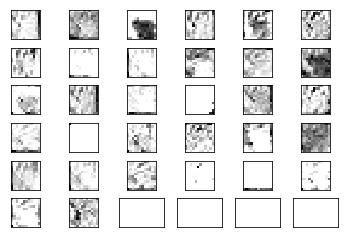

<Figure size 432x288 with 0 Axes>

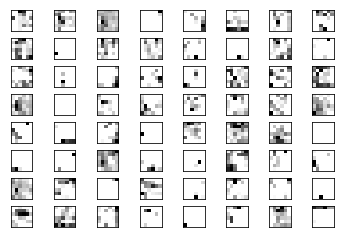

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix

import cache    # module from Hvass Labs
import dataset  # module from Hvass Labs
import download # module from Hvass Labs
import cifar10  # module from Hvass Labs

import utils

# this line should be commented out for regular python run 
%matplotlib inline  
# this line should be commented out for regular python run 


""" Hyperparameter """
data_size_train = 50000
data_size_test = 10000
batch_size = 100
lr = 1e-3
epoch = 15
cropped_size = (24, 24, 3)
img_size_cropped = 24


""" Data Loading """
def load_cifar10():
    # make directory if not exist
    if not os.path.isdir("data"):
        os.mkdir("data")
    if not os.path.isdir("data/CIFAR-10"):
        os.mkdir("data/CIFAR-10")

    # download and extract if not done yet
    # data is downloaded 
    # from data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    # to data_path  = "data/CIFAR-10/"
    cifar10.data_path = "data/CIFAR-10/"
    cifar10.maybe_download_and_extract()

    # load data
    x_train, y_train_cls, y_train = cifar10.load_training_data()
    x_test, y_test_cls, y_test = cifar10.load_test_data()
    class_names = cifar10.load_class_names()

    x_train = x_train.astype(np.float32)
    y_train_cls = y_train_cls.astype(np.int32)
    y_train = y_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    y_test_cls = y_test_cls.astype(np.int32)
    y_test = y_test.astype(np.float32)

    data = (x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names)

    return data

# x_train.shape     :  (50000, 32, 32, 3)
# x_test.shape      :  (10000, 32, 32, 3)
# y_train.shape     :  (50000, 10)
# y_test.shape      :  (10000, 10)
# y_train_cls.shape :  (50000,)
# y_test_cls.shape  :  (10000,)
data = load_cifar10()
x_train, y_train_cls, y_train, x_test, y_test_cls, y_test, class_names = data


""" Graph Construction """
# tf.random.set_random_seed(337)

# placeholders
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')
y_cls = tf.placeholder(tf.int32, shape=(None,), name='y_cls')
is_train = tf.placeholder(tf.bool, shape=(), name='is_train')

# cropping ##########################################################################
# crop original images x by random cropping during train and 
# center cropping during test

def pre_process_img_train(img): 
    # For training, add the following to the TensorFlow graph.

    # Randomly crop the input image.
    # cropped_size = (img_size_cropped, img_size_cropped, num_channels) 
    image = tf.random_crop(img, size=cropped_size)

    # Randomly flip the image horizontally.
    image = tf.image.random_flip_left_right(image)

    # Randomly adjust hue, contrast and saturation.
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

    # Some of these functions may overflow and result in pixel
    # values beyond the [0, 1] range. It is unclear from the
    # documentation of TensorFlow 0.10.0rc0 whether this is
    # intended. A simple solution is to limit the range.

    # Limit the image pixels between [0, 1] in case of overflow.
    image = tf.minimum(image, 1.0)
    image = tf.maximum(image, 0.0)

    return image

def pre_process_img_test(img): #, is_train=is_train, cropped_size=cropped_size):
    # For not training, i.e., test, add the following to the TensorFlow graph.

    # Crop the input image around the centre so it is the same
    # size as images that are randomly cropped during training.
    image = tf.image.resize_image_with_crop_or_pad(img, \
                                                   target_height=img_size_cropped, \
                                                   target_width=img_size_cropped)

    return image

def pre_process_img(img): 
    image = tf.cond(is_train, lambda: pre_process_img_train(img), lambda: pre_process_img_test(img))
    return image
    
x_cropped = tf.map_fn(lambda img: pre_process_img(img), x)
# cropping ##########################################################################

# weights and layers #################################################################

# convolution layer 1
# input and input.shape:   x,     (None, 24, 24, 3)
# output and output.shape: conv1, (None, 12, 12, 32)
conv1_W = tf.get_variable("conv1_W", \
                          shape=(3,3,3,32), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
c1 = tf.nn.conv2d(x_cropped, conv1_W, \
                  strides=(1,1,1,1), padding='SAME') # (None, 24, 24, 32)
co1 = tf.nn.relu(c1) # (None, 24, 24, 32)
conv1 = tf.nn.max_pool(co1, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 12, 12, 32)

# convolution layer 2
# input and input.shape:   conv1, (None, 12, 12, 32)
# output and output.shape: conv2, (None, 6, 6, 64)
conv2_W = tf.get_variable("conv2_W", \
                          shape=(3,3,32,64), \
                          initializer=tf.truncated_normal_initializer(stddev=0.1))
c2 = tf.nn.conv2d(conv1, conv2_W, strides=(1,1,1,1), \
                     padding='SAME') # (None, 12, 12, 64)
co2 = tf.nn.relu(c2) # (None, 12, 12, 64)
conv2 = tf.nn.max_pool(co2, ksize=(1,2,2,1), strides=(1,2,2,1), \
                       padding='SAME') # (None, 6, 6, 64)

# fully connected layer
# input and input.shape:   conv2, (None, 6, 6, 64)
# output and output.shape: fc,    (None, 256) 
flatten = tf.reshape(conv2, (-1, 2304)) # (None, 2304) 
fc_W = tf.get_variable("fc_W", \
                        shape=(2304,256), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
fc = tf.matmul(flatten, fc_W) # (None, 256) 
fc = tf.nn.relu(fc) # (None, 256) 

# output layer
# input and input.shape:   fc,     (None, 256) 
# output and output.shape: logits, (None, 10) 
out_W = tf.get_variable("out_W", \
                        shape=(256, 10), \
                        initializer=tf.truncated_normal_initializer(stddev=0.1))
logits = fc @ out_W # (None, 10) 

# weights and layers #################################################################

# y_pred, and y_pred_cls 
y_pred = tf.nn.softmax(logits, name='y_pred') # probabilities
y_pred_cls = tf.argmax(logits, axis=1, output_type=tf.int32)

# cross_entropy cost function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y)
cost = tf.reduce_mean(cross_entropy)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

# test accuracy
# you have to put test sets to compute test_accuracy
correct_bool = tf.equal(y_cls, y_pred_cls)
test_accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32))


""" Train and Test """
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    
    # run gradient descent
    for i in range(epoch):
        if 1:
            # perform random permutaion
            idx = np.random.permutation(np.arange(data_size_train)) 
            x_batch = x_train[idx]
            y_batch = y_train[idx]
        else:
            # don't perform random permutaion
            x_batch = x_train
            y_batch = y_train
            
        cost_this_epoch = 0
        for batch_number in range(int(data_size_train/batch_size)): 
            x_b = x_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            y_b = y_batch[batch_number*batch_size:(batch_number+1)*batch_size]
            feed_dict = {x: x_b, y: y_b, is_train: True}
            _, cost_now = sess.run([train_op, cost], feed_dict=feed_dict)
            cost_this_epoch += cost_now
            
        print('epoch_number    :', i)
        print('cost_this_epoch :', cost_this_epoch)
        print()

            
    # compute test accuracy and print confusion matrix 
    x_data = x_test
    y_data = y_test
    y_cls_data = y_test_cls
    y_test_cls_pred = np.zeros(shape=(data_size_test), dtype=np.int32)
    test_accuracy_list = []
    for batch_number in range(int(data_size_test/batch_size)): 
        x_b = x_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_b = y_data[batch_number*batch_size:(batch_number+1)*batch_size]
        y_cls_b = y_cls_data[batch_number*batch_size:(batch_number+1)*batch_size]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, is_train: False}
        test_accuracy_temp, y_test_cls_pred_now = sess.run([test_accuracy,y_pred_cls],
                                                           feed_dict=feed_dict)
        test_accuracy_list.append(test_accuracy_temp)
        y_test_cls_pred[batch_number*batch_size:(batch_number+1)*batch_size] = \
            y_test_cls_pred_now
        
    print('Test Accuracy: ', np.mean(np.array(test_accuracy_list)))
    
    cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(10))
    plt.yticks(tick_marks, range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    plt.savefig('img/cm.png')
    plt.close()
    
    
    # collect info of first 9 test images with false prediction
    images = []
    cls_true = []
    cls_pred = []
    img_shape = (32, 32, 3)
    num_false_prediction = 0
    i = 0
    while num_false_prediction < 9:
        x_b = [x_test[i]]
        y_b = [y_test[i]]
        y_cls_b = [y_test_cls[i]]
        feed_dict = {x: x_b, y: y_b, y_cls: y_cls_b, is_train: False}
        bool_now, y_pred_cls_now = sess.run([correct_bool, y_pred_cls], \
                                            feed_dict=feed_dict)
        if bool_now[0] == False:
            images.append(x_b[0])
            cls_true.append(y_cls_b[0])
            cls_pred.append(y_pred_cls_now[0])
            num_false_prediction += 1
        i += 1
    images = images[0:9]
    cls_true = cls_true[0:9]
    cls_pred = cls_pred[0:9]

        
    # plot 9 test images with false prediction
    n = len(images)
    sqrt_n = int(np.ceil(np.sqrt(n)))
    
    plt.figure()
    fig, axes = plt.subplots(sqrt_n, sqrt_n)
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i < n:
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            if (cls_true is not None) and (cls_pred is not None):
                xlabel = "True: {0}\nPred: {1}".format(class_names[cls_true[i]], \
                                                       class_names[cls_pred[i]])
            elif (cls_true is not None) and (cls_pred is None):
                xlabel = "True: {0}".format(class_names[cls_true[i]])
            elif (cls_true is None) and (cls_pred is not None):
                xlabel = "Pred: {0}".format(class_names[cls_pred[i]])
            else:
                xlabel = ""
            ax.set_xlabel(xlabel)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    
    
    # plot_test_images_in_input_conv1_conv2_layers(self, num_test_images=2):
    num_test_images = 5
    for i in range(num_test_images):
        image0 = x_test[i]
        utils.plot_one_image(image0, (32, 32, 3), cls_true=None, cls_pred=None)

        feed_dict = {x: [image0], is_train: False}
        image0_layer1, image0_layer2 = sess.run([conv1, conv2], feed_dict=feed_dict)
        
        # image0_layer1.shape = (1, 16, 16, 32)
        # image0_layer2.shape = (1, 8, 8, 64)
        image0_layer1 = image0_layer1[0]
        image0_layer2 = image0_layer2[0]

        utils.plot_many_images_3d(image0_layer1)
        utils.plot_many_images_3d(image0_layer2)